# Code supporting the paper 'Ancient Levantine demography follows ecological stochasticity' (Wachtel et al., 2025)

### Install packages, if neccessary

In [1]:
!pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 imbalanced-learn==0.12.3 matplotlib==3.9.2 scipy==1.13.1 openpyxl==3.1.5

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, accuracy_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import KDTree

### Early Period Analysis

In [3]:
periods = ['Late_Chal', 'EBI', 'EBII', 'EBIII', 'IB']

#### Data import and processing

In [4]:
df_early = pd.read_excel('data/settlement_data.xlsx','Early Periods')
df_early.loc[df_early['size(ha)']==0, 'size(ha)'] = None

#### Descriptive Statistics

In [5]:
# settlements by status and period
r = []
for i in range(len(periods)):
    period = periods[i]
    s = df_early[df_early[period]==1]
    if i == 0:
        r.append([period, len(s), len(s[s[periods[i+1]]==1]), len(s[s[periods[i+1]]==0]), np.nan])
    elif i == len(periods)-1:
        r.append([period, len(s), np.nan, np.nan, len(s[s[periods[i-1]]==0])])
    else:
        r.append([period, len(s), len(s[s[periods[i+1]]==1]), len(s[s[periods[i+1]]==0]), len(s[s[periods[i-1]]==0])])
pd.DataFrame(r, columns=['Period', '#', 'Continued', 'Abandoned', 'New'])

,Period,#,Continued,Abandoned,New
0,Late_Chal,107,74.0,33.0,NaN
1,EBI,170,78.0,92.0,96.0
2,EBII,123,33.0,90.0,45.0
3,EBIII,35,16.0,19.0,2.0
4,IB,71,NaN,NaN,55.0


In [6]:
# seetlment population size, by period and status 
pd.DataFrame([df_early[df_early.Late_Chal==1]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.Late_Chal==1) & (df_early.EBI==1)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.Late_Chal==1) & (df_early.EBI==0)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[df_early.EBI==1]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBI==1) & (df_early.EBII==1)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBI==1) & (df_early.EBII==0)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[df_early.EBII==1]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBII==1) & (df_early.EBIII==1)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBII==1) & (df_early.EBIII==0)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[df_early.EBIII==1]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBIII==1) & (df_early.IB==1)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']],
             df_early[(df_early.EBIII==1) & (df_early.IB==0)]['size(ha)'].describe()[['50%', '25%', '75%', 'mean']]],
            index=[('L. Chal', 'All'), ('L. Chal', 'Continued'), ('L. Chal', 'Abandoned'),
                  ('EBI', 'All'), ('EBI', 'Continued'), ('EBI', 'Abandoned'),
                  ('EBII', 'All'), ('EBII', 'Continued'), ('EBII', 'Abandoned'),
                  ('EBIII', 'All'), ('EBIII', 'Continued'), ('EBIII', 'Abandoned')])

,50%,25%,75%,mean
"(L. Chal, All)",1.5,1.000,3.25,2.859559
"(L. Chal, Continued)",2.0,1.000,5.00,3.522093
"(L. Chal, Abandoned)",1.0,0.800,2.00,1.720000
"(EBI, All)",2.0,1.000,4.00,3.723113
"(EBI, Continued)",3.0,1.725,5.00,5.156667
"(EBI, Abandoned)",1.0,0.525,2.00,1.853261
"(EBII, All)",3.0,1.375,5.00,4.642708
"(EBII, Continued)",5.0,2.750,12.00,9.507407
"(EBII, Abandoned)",2.0,1.000,4.00,2.739130
"(EBIII, All)",5.0,3.000,12.00,9.265517


####  Hypothesis 1: Smaller settlements are more likely to be abandoned

In [7]:
abandoned = pd.DataFrame([], columns=['Heb_Name', 'size(ha)', 'Abandoned', 'Period'])
for i in range(len(periods)-1):
    period = periods[i]
    s = df_early[(df_early[period]==1) & (~df_early['size(ha)'].isnull())].copy()
    s['Period'] = period
    s['Abandoned'] = 'no'
    s.loc[s[periods[i+1]]==0, 'Abandoned'] = 'yes'
    abandoned = pd.concat((abandoned, s[['Heb_Name', 'size(ha)', 'Abandoned', 'Period']]))
abandoned.rename(columns={'size(ha)':'Size'}, inplace=True)

C:\Users\Owner\AppData\Local\Temp\ipykernel_12000\887774367.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  abandoned = pd.concat((abandoned, s[['Heb_Name', 'size(ha)', 'Abandoned', 'Period']]))


In [8]:
# 2-way ANOVA
model = ols('Size ~ C(Period) + C(Abandoned) + C(Period):C(Abandoned)', data=abandoned[~abandoned.Size.isnull()]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Period),1035.592540,3.0,9.522739,5.098874e-06
C(Abandoned),460.327942,1.0,12.698768,4.274448e-04
C(Period):C(Abandoned),1408.014289,3.0,12.947325,5.809355e-08
Residual,10548.695341,291.0,NaN,NaN


#### Hypothesis 2: Niche maps remain stable, settlement maps change 

In [9]:
# read niche map data, produced via the R maxEnt code
niche_maps = {}
for period in ['Late_Chal', 'EBI', 'EBII', 'EBIII', 'IB']:
    niche_maps[period] = pd.read_csv('data/'+period+'_map.csv')

In [10]:
# compute niche maps' Kappa score
kappa_results = []
for period1, period2 in [('Late_Chal', 'EBI'), ('EBI', 'EBII'), ('EBII', 'EBIII'), ('EBIII', 'IB')]:
    kappa = cohen_kappa_score(niche_maps[period1].Niche==1, niche_maps[period2].Niche==1)
    kappa_results.append((period1, period2, kappa))
kappa_df = pd.DataFrame(kappa_results, columns=['Period 1', 'Period 2', 'Kappa'])
kappa_df

,Period 1,Period 2,Kappa
0,Late_Chal,EBI,0.431556
1,EBI,EBII,0.541992
2,EBII,EBIII,0.516257
3,EBIII,IB,0.291178


In [11]:
# compute settlment maps' Kappa score
kappa_results = []
for period1, period2 in [('Late_Chal', 'EBI'), ('EBI', 'EBII'), ('EBII', 'EBIII'), ('EBIII', 'IB')]:
    kappa = cohen_kappa_score(df_early[period1], df_early[period2])
    kappa_results.append((period1, period2, kappa))
kappa_df = pd.DataFrame(kappa_results, columns=['Period 1', 'Period 2', 'Kappa'])
kappa_df

,Period 1,Period 2,Kappa
0,Late_Chal,EBI,0.141376
1,EBI,EBII,0.069835
2,EBII,EBIII,0.281250
3,EBIII,IB,0.165567


### Late Period Analysis

#### Data import and processing

In [12]:
periods = [1596, 1881, 1931]

In [13]:
# read data for each period
df_Ottoman = pd.read_excel('data/settlement_data.xlsx','1596')
df_PEF = pd.read_excel('data/settlement_data.xlsx', '1881')
df_Man = pd.read_excel('data/settlement_data.xlsx', '1931')

In [14]:
# merge into single DataFrame
df_Ottoman['Period'] = 1596
df_PEF['Period'] = 1881
df_Man['Period'] = 1931
df = pd.concat([df_Ottoman, df_PEF, df_Man])

In [15]:
df['Coords'] = (df.POINT_X).round(0).astype(str) + ',' + (df.POINT_Y).round(0).astype(str) # round coordinates
df.loc[df.Population<=0, 'Population'] = np.nan

In [16]:
# identify newly established settlements
df['New'] = np.nan
for i in range(1, len(periods)):
    df.loc[(df.Period==periods[i]) & (~df.Coords.isin(df[df.Period==periods[i-1]].Coords)), 'New'] = 'yes'
    df.loc[(df.Period==periods[i]) & (df.Coords.isin(df[df.Period==periods[i-1]].Coords)), 'New'] = 'no'

C:\Users\Owner\AppData\Local\Temp\ipykernel_12000\721990989.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'yes' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df.Period==periods[i]) & (~df.Coords.isin(df[df.Period==periods[i-1]].Coords)), 'New'] = 'yes'


#### Descriptive statistics

In [17]:
# settlements by period and type
pd.DataFrame([[p, df[df.Period==p].Village.count(), df[(df.Period==p) & (df.Continued=='yes')].Village.count(),
              df[(df.Period==p) & (df.Continued=='no')].Village.count(),
              df[(df.Period==p) & (df.New=='yes')].Village.count()] for p in periods],
            columns=['Period', '#', 'Continued', 'Abandoned', 'New'])

,Period,#,Continued,Abandoned,New
0,1596,167,96,71,0
1,1881,140,116,24,44
2,1931,232,0,0,116


In [18]:
# seetlment population size, by period and status 
pd.DataFrame([df[df.Period==1596].Population.describe()[['50%', '25%', '75%', 'mean']],
             df[(df.Period==1596) & (df.Continued=='yes')].Population.describe()[['50%', '25%', '75%', 'mean']],
             df[(df.Period==1596) & (df.Continued=='no')].Population.describe()[['50%', '25%', '75%', 'mean']],
             df[df.Period==1881].Population.describe()[['50%', '25%', '75%', 'mean']],
             df[(df.Period==1881) & (df.Continued=='yes')].Population.describe()[['50%', '25%', '75%', 'mean']],
             df[(df.Period==1881) & (df.Continued=='no')].Population.describe()[['50%', '25%', '75%', 'mean']]], 
             index=[(1596, 'All'), (1596, 'Continued'), (1596, 'Abandoned'), (1881, 'All'), (1881, 'Continued'), (1881, 'Abandoned')])

,50%,25%,75%,mean
"(1596, All)",145.0,70.0,330.5,328.257485
"(1596, Continued)",231.0,110.0,436.0,465.010417
"(1596, Abandoned)",90.0,50.0,151.0,143.352113
"(1881, All)",200.0,106.0,400.0,474.857143
"(1881, Continued)",200.0,150.0,400.0,535.344828
"(1881, Abandoned)",100.0,80.0,170.0,182.500000


####  Hypothesis 1: Smaller settlements are more likely to be abandoned

In [19]:
# identify abandoned settlements 
df['Abandoned'] = np.nan
df.loc[df.Continued=='yes', 'Abandoned'] = 0
df.loc[df.Continued=='no', 'Abandoned'] = 1

In [20]:
# 2-way ANOVA
model = ols('Population ~ C(Period) + C(Abandoned) + C(Period):C(Abandoned)', data=df[df.Period!=1931]).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Period),2.743384e+05,1.0,0.288097,0.591836
C(Abandoned),6.685577e+06,1.0,7.020883,0.008479
C(Period):C(Abandoned),1.300466e+04,1.0,0.013657,0.907046
Residual,2.885292e+08,303.0,NaN,NaN


#### Supporting analysis for Hypothesis 1: Feature importance of population size in predicting abandonment

In [21]:
df['rain'] = df.Precip__11 + df.Precip_12+df.Precip_1 + df.Precip_2+df.Precip_3 # compute annual rainfall

In [22]:
# produce features array (X) and labels (y)
X = df[df.Period != 1931][['POINT_X', 'POINT_Y', 'Population', 'Height', 'Slope_100', 'NEAR_Spring',
       'NEAR_Chlak', 'rain', 'NEAR_Sea']].rename(columns={'POINT_X':'Longitude', 'POINT_Y':'Latitude', 'Height':'Elevation',
                                                              'Slope_100':'Slope', 'NEAR_Spring':'Distance from spring',
                                                              'NEAR_Chlak': 'Soft rock',
                                                              'rain': ' Annual rain',
                                                              'NEAR_Sea': 'Distance from sea',
                                                              'Population': 'Population size'
                                                            })
y = np.where(df[df.Period != 1931].Continued=='yes', 1, 0)

In [23]:
# Apply Random Undersampling to balance the classes
oversampler = RandomOverSampler()
X, y = oversampler.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
# Create a DummyClassifier with strategy 'most_frequent' to implement ZeroR
zeroR_model = DummyClassifier(strategy='most_frequent')

# Fit the ZeroR model
zeroR_model.fit(X_train, y_train)

# Predict the majority class for all instances
y_pred_zeroR = zeroR_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_zeroR))
print("ZeroR Accuracy:", accuracy_score(y_test, y_pred_zeroR))

              precision    recall  f1-score   support

           0       0.48      1.00      0.65        41
           1       0.00      0.00      0.00        44

    accuracy                           0.48        85
   macro avg       0.24      0.50      0.33        85
weighted avg       0.23      0.48      0.31        85

ZeroR Accuracy: 0.4823529411764706


C:\Users\Owner\anaconda3\envs\test_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\envs\test_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\envs\test_env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [25]:
# Train random forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Evaluate random forest model
rf_y_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_y_pred))
print("Random Forest Accuracy: ", accuracy_score(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        41
           1       0.84      0.84      0.84        44

    accuracy                           0.84        85
   macro avg       0.84      0.84      0.84        85
weighted avg       0.84      0.84      0.84        85

Random Forest Accuracy:  0.8352941176470589


In [26]:
# Save and print feature importance values
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("Feature Importance (Random Forest):")
print(feature_importances.sort_values(ascending=False))

# Sort feature importance data by values in descending order
sorted_feature_importance = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importance values
features = [x[0] for x in sorted_feature_importance]
importance = [x[1] for x in sorted_feature_importance]

Feature Importance (Random Forest):
Population size         0.260513
Soft rock               0.140895
Distance from spring    0.113403
Latitude                0.091899
Slope                   0.089315
Distance from sea       0.084177
Longitude               0.074775
 Annual rain            0.073180
Elevation               0.071842
dtype: float64


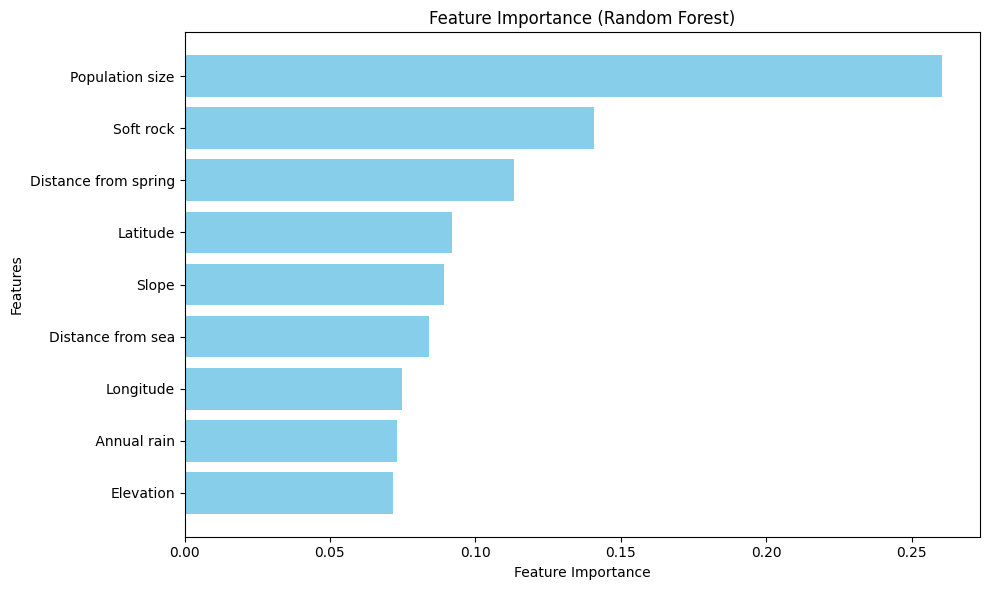

In [27]:
# Create feature importance bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
plt.tight_layout()
plt.show()

#### Hypothesis 2: Niche maps remain stable, settlement maps change

In [28]:
# read niche map data, produced via the R maxEnt code
niche_maps = {}
for period in ['1596', '1881', '1931']:
    niche_maps[period] = pd.read_csv('data/'+period+'_map.csv')

In [29]:
# compute niche maps' Kappa score
kappa_results = []
for period1, period2 in [('1596', '1881'), ('1881', '1931')]:
    kappa = cohen_kappa_score(niche_maps[period1].Niche==1, niche_maps[period2].Niche==1)
    kappa_results.append((period1, period2, kappa))
kappa_df = pd.DataFrame(kappa_results, columns=['Period 1', 'Period 2', 'Kappa'])
kappa_df

,Period 1,Period 2,Kappa
0,1596,1881,0.622049
1,1881,1931,0.506998


In [30]:
# settlement kappa scores, computed based on the existence of a settlement in the locations in a period and its subsequent period
# to avoid creating very close locations, locations are grouped based on a 100m tolerance

# Define tolerance (100 meters) and periods
tolerance = 100
periods = [1596, 1881, 1931]

# Group points within the tolerance using KDTree
tree = KDTree(df[['POINT_X', 'POINT_Y']].values)
groups = tree.query_ball_tree(tree, r=tolerance)

# Map each group to a representative point (first in the group)
unique_points = {tuple(df.iloc[group[0]][['POINT_X', 'POINT_Y']]): group for group in groups}

# Create a new DataFrame with unique points and periods
kappa_df = pd.DataFrame({
    'POINT_X': [point[0] for point in unique_points.keys()],
    'POINT_Y': [point[1] for point in unique_points.keys()],
    **{period: 0 for period in periods}
})

# Populate the periods columns
for unique_point, group in unique_points.items():
    for idx in group:
        period = df.iloc[idx]['Period']
        if period in periods:
            kappa_df.loc[(kappa_df['POINT_X'] == unique_point[0]) & (kappa_df['POINT_Y'] == unique_point[1]), period] = 1

In [31]:
# compute settlments maps' Kappa score
kappa_results = []
for period1, period2 in [(1596, 1881), (1881, 1931)]:
    kappa = cohen_kappa_score(kappa_df[period1], kappa_df[period2])
    kappa_results.append((period1, period2, kappa))
kappa_df = pd.DataFrame(kappa_results, columns=['Period 1', 'Period 2', 'Kappa'])
kappa_df

,Period 1,Period 2,Kappa
0,1596,1881,0.270347
1,1881,1931,0.189414


#### Hypothesis 3: New settlements are located near other settlements

Since the analysis includes simulation - computing distance of randomly selected points from existing settlements - we perform multiple random sampling of both new settlements and random points and compute the average distance to the 5 nearest settlements for each such set. Thus, the result is 200 mean distance values - for 100 random samples of new settlements and 100 random samples of random points - for each period

In [32]:
settl_num = 5 # number of nearest settlements to identify
settelment_type = [] # documents whether new settlements or random points for each observation
DIS = [] # documents mean distances for each observation
period = [] # documents period for each observation

for j in [1,2]:
    p = periods[j]
    N = round(len(df[(df.Period==p) & (df.New=='yes')])*0.75) # number of observations to sample - 75% of the number of new settlements

    for i in range(0,100): # 100 random sets
        rand_xy = niche_maps[str(p)][['POINT_X', 'POINT_Y']].sample(N) # draw random points based on niche map for the period

        new_settelment = df[(df.Period==p) & (df.New=='yes')][['POINT_X', 'POINT_Y']].sample(N) # draw new settlements
        old_settelment = df[df.Period==p][['POINT_X', 'POINT_Y']] # compare to all settlements from the period, including new ones

        # distance matrix between new and 'old' settlements
        dis = cdist(new_settelment[['POINT_X', 'POINT_Y']], old_settelment[['POINT_X', 'POINT_Y']], 'euclidean')
        dis[dis<100] = None
        dis.sort(axis=1)
        dis = dis[:,1:settl_num] # find distances to 5 nearest settlements per new settlement
        min_dis = np.nanmean(dis,axis=1) # mean distance per settlement
        min_dis = np.nanmean(min_dis) # mean distance for dataset

        # distance matrix between random points and 'old' settlements
        rdis = cdist(rand_xy[['POINT_X', 'POINT_Y']], old_settelment[['POINT_X', 'POINT_Y']], 'euclidean')
        rdis[rdis<100] = None
        rdis.sort(axis=1)
        rdis = rdis[:,1:settl_num] # find distances to 5 nearest settlements per random point
        rmin_dis = np.nanmean(rdis,axis=1) # mean distance per settlement
        rmin_dis = np.nanmean(rmin_dis) # mean distance for dataset

        DIS.append(rmin_dis) # append distance to random points
        DIS.append(min_dis) # append distance to new settlements
        settelment_type.append('random')
        settelment_type.append('new settelment')

        period.append(p)
        period.append(p)

In [33]:
# turn results into DataFrame and compute 2-way ANOVA
result = pd.DataFrame()
result['Period'] = period
result['settelment_type'] = settelment_type
result['Distance'] =  DIS
model = ols('Distance ~ C(Period) + C(settelment_type) + C(Period):C(settelment_type)', data=result).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Period),1.405515e+08,1.0,2640.489967,2.931021e-177
C(settelment_type),4.644821e+07,1.0,872.605447,3.703091e-102
C(Period):C(settelment_type),1.591769e+07,1.0,299.039816,2.571904e-50
Residual,2.107882e+07,396.0,NaN,NaN
